# Assignement: non Boltzmann sampling
### We use Metropolis MC and non-Boltzmann sampling to compute the energy barrier for a Cu adatom on a Cu(111) surface to migrate from an FCC adsorption site to an HCP adsorption site
<img src="Cu_adatom.png" width=300>

### To compute the energy of the configurations we will use lammps and the EAM potential for Cu

### We will compare the Enthalpy of the different configurations with the free energy derived from the MC statistics.
### We need an "umbrella" of energy to force the adatom to move from its initial position to the HCP site.

### Throughout the notebook, energies are in eV and distances in A

In [1]:
# Import libraries and read geometry files of the Cu clusters
import numpy as np
from scipy.constants import physical_constants
from ase import Atoms
from ase.io import read,write
import nglview as nv
import time
import matplotlib.pyplot as plt
from IPython.display import Audio

workdir = !pwd
workdir = workdir[0]

cua = read("Cu_a.xyz")
cub = read("Cu_b.xyz")
cuts = read("Cu_ts.xyz")
natoms=len(cua)
cua.center()
cub.center()
cuts.center()
kb=physical_constants['Boltzmann constant in eV/K'][0]

### we want to reduce the distance between the adatom (ID 83) and the atom with ID 13 from 3.7A to 2.7A

In [2]:
print(cua.get_distance(83, 13, mic=True, vector=False),  cub.get_distance(83, 13, mic=True, vector=False))

3.6920960402302985 2.674618969626189


In [3]:
#Functions to visualize the geometries
def view_structure(structure):
    """
    Use the ASE library to view an atoms object.

    Parameters
    ----------

    structure: Atoms object

    Returns
    -------

    NGLWidget with GUI: object to be viewed
    
    """
    #t1=make_supercell(structure,[[3,0,0],[0,3,0],[0,0,3]])
    t = nv.ASEStructure(structure)
    w = nv.NGLWidget(t, gui=True)
    w.add_unitcell()
    w.add_spacefill()
    return w

def view_trajectory(trajectory):
    t2 = nv.ASETrajectory(trajectory)
    w2 = nv.NGLWidget(t2, gui=True)
    #w2.add_unitcell()
    w2.add_ball_and_stick()
    return w2

In [4]:
# Text strings used for lammps inputs
inp=f"""# (written by ASE)
clear
atom_style atomic
units metal
boundary f f f
atom_modify sort 0 0.0

### interactions
pair_style eam
read_data data_lammps_cu
pair_coeff * * Cu_u3.eam
mass 1 63.546

### run
fix fix_nve all nve
dump dump_all all custom 1 {workdir}/trj_lammps.bin id type x y z vx vy vz fx fy fz
thermo_style custom step temp press cpu pxx pyy pzz pxy pxz pyz ke pe etotal vol lx ly lz atoms
thermo_modify flush yes format float %23.16g
thermo 1
run 0
print "__end_of_ase_invoked_calculation__"
log /dev/stdout"""
with open(f"{workdir}/lammps_cu.in", "w") as text_file:
    text_file.write(inp)

In [5]:
## text string for the input atomic positions
data_lammps0=f"""data_lammps={workdir}/data_lammps_cu (written by ASE)

{natoms}       atoms
1  atom types
0.0      20.0  xlo xhi
0.0      20.0  ylo yhi
0.0      20.0  zlo zhi


"""

In [6]:
def lammps_positions(atoms):
    """Function to write the postions of an ASE Atoms object in the lammps input
    -iput: ASE Atoms object
    -output: string with positions
    """
    #lmpid={'C':1,'H':2}
    positions="""Atoms
    
"""
    for i,atom in enumerate(atoms):
        positions+=f"{i+1:4} 1 {atom.x:14.8} {atom.y:14.8} {atom.z:14.8} \n"
    return positions

In [7]:
def get_energy(atoms):  
    """Due to a bug in the lammps ASE calculator we write an ad-hoc function to run a lammps calculation
    to compute the energy of a configuration
    -iput ASE Atoms object
    -outpt Enthalpy in eV
    """
    data_lammps = data_lammps0 + lammps_positions(atoms)
    with open(f"{workdir}/data_lammps_cu", "w") as text_file:
        text_file.write(data_lammps)
    out = !lmp_serial < ./lammps_cu.in  | grep -A 100000 "Step          Temp          Press"
    # parsing of lammps.log (out) to get the energy of the configuration
    results = out[1].split()
    return float(results[11])

### Familiarizing with the system: energy of "FCC" "HCP" and "BRIDGE" configuration (not optimized)

In [8]:
# testing the get_energy function
print(f"Energy a: {get_energy(cua)} Energy ts: {get_energy(cuts)} Energy b: {get_energy(cub)}")

Energy a: -247.8751645924224 Energy ts: -247.8490636318834 Energy b: -247.8731646620279


## Creating the bias potential

In [9]:
npoints=200 # we discretize the range 2.4<-->3.9 for the distance between atoms 83 and 13
steps = 5
maxe = 0.2
d1=2.20
d2=4.00
dl = d2-d1 
n1 = int((d2-3.68)/dl*(npoints)) #initial configuration
n2 = int((d2-3.0)/dl*(npoints)) # close to halfway
n3 = int((d2-2.60)/dl*(npoints)) #final configuration
de1 = maxe/(n2-n1) * steps
de2 = maxe/(n3-n2+10) * steps
umbrellas=np.zeros(npoints)
num=0
ene=0
for i in range(n1,n2,5):
    ene+=de1
    umbrellas[i:i+5]=ene
lasti = i
for i in range(lasti,n3,5):
    ene-=de2
    umbrellas[i:min(i+5,npoints)]=ene

def umbrellai(atoms):
    """Function to set ad-hoc energy values in the intervals of the distance collective variable
    -iput ASE Atoms 
    -output index in the array of distances, distance between atoms 83 and 13, energy of the umbrella
    """
    dist = atoms.get_distance(83, 13, mic=True, vector=False)
    d1=2.20
    d2=4.00
    dl = d2-d1
    dr = (d2-dist)/dl
    index = int(dr*(npoints))
    if 0<=dr<=1:
        return index, dist, umbrellas[index]
    else:
        return None, dist,0.0 

In [10]:
umbrellai(cub)

(147, 2.674618969626189, 0.06237816764132548)

In [11]:
# check the umbrella
umbrellas

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.01315789, 0.01315789, 0.01315789, 0.01315789, 0.01315789,
       0.02631579, 0.02631579, 0.02631579, 0.02631579, 0.02631579,
       0.03947368, 0.03947368, 0.03947368, 0.03947368, 0.03947368,
       0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.05263158,
       0.06578947, 0.06578947, 0.06578947, 0.06578947, 0.06578947,
       0.07894737, 0.07894737, 0.07894737, 0.07894737, 0.07894737,
       0.09210526, 0.09210526, 0.09210526, 0.09210526, 0.09210526,
       0.10526316, 0.10526316, 0.10526316, 0.10526316, 0.10526

Text(0, 0.5, 'Umbrella bias (eV)')

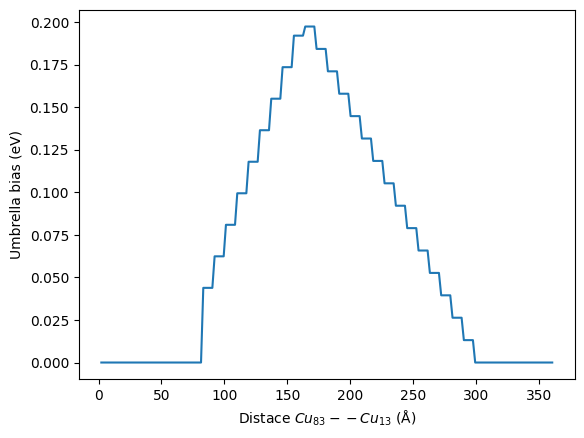

In [12]:
fig, ax = plt.subplots()
ax.plot(np.array([d1+i*dl for i in range(200)]),np.flip(umbrellas))
ax.set_xlabel("Distace $Cu_{83}--Cu_{13}$ (Å)")
ax.set_ylabel("Umbrella bias (eV)")

## MC loop
#### In the following cell, core of the MC procedure, we use "next" and "previous" to be able to store quantities in case MC moves are rejected. We store for all configurations: the distance betweem atoms 83 and 13, the energy. We store, for animations, configurations every 100 steps. For simplicity we move only the adatom.

In [13]:
onehalf = np.zeros([natoms,3])
enthalpies = np.zeros(npoints)
onehalf.fill(0.5) #needed to shift the random numbers
T = 170 #temperature in K
beta =1.0/(kb*T)

previous_geo = cua

previous_enthalpy = get_energy(previous_geo)
previous_index, previous_dist,ene_umbrella = umbrellai(previous_geo)
previous_ene = previous_enthalpy - ene_umbrella
iwrite=1000
niter=1000000 #you can reduce this to 600000 and it should take less than 1 hour
dx=0.05 #maximum aplitude of the MC move
start = time.time()
geometries=[]
distances = []
try:
    rm_traj = !rm traj_cu.xyz
except:
    pass


previous_dist = previous_geo.get_distance(83, 13, mic=True, vector=False)
naccepted = 0
try:
    for i in range(niter):
        next_geo = previous_geo.copy()
        next_geo.positions[83] += dx*(np.random.rand(3) - np.array([0.5,0.5,0.5])) # BE CAREFUL HERE
        #next_geo.positions += dx*(np.random.rand(natoms,3) - onehalf) #this would be to move all atoms
        next_geo.center()
        new_index, next_dist,ene_umbrella = umbrellai(next_geo)
        if new_index is None:
            print(f"Exit: distance {next_dist} out of range. You can either change dx and reduce T or add walls in the umbrella")
            break
        new_enthalpy =  get_energy(next_geo)
        new_ene = new_enthalpy - ene_umbrella
        
        # write here the Metropolis condition for acceptance
        rho =  #random number in [0,1)
        if rho #..... enter here the  Metropolis condition:
            # update old variables with new accepted values
            naccepted+=1
            previous_ene = new_ene
            previous_enthalpy = new_enthalpy
            previous_geo = next_geo.copy()
            previous_dist = next_dist
            previous_index = new_index
            
        if not np.mod(i,iwrite):
            geometries.append(previous_geo)
        if not np.mod(i,50000):
            print(f"Done {i} steps in {int(time.time() -start)} seconds ")
        distances.append(previous_dist)
        enthalpies[previous_index] += previous_enthalpy
except:
    pass

end = time.time()
print(end - start) 
print(naccepted)

Done 0 steps in 0 seconds 
Done 50000 steps in 402 seconds 
Done 100000 steps in 802 seconds 
Done 150000 steps in 1199 seconds 
Done 200000 steps in 1602 seconds 
Done 250000 steps in 2008 seconds 
Done 300000 steps in 2416 seconds 
Done 350000 steps in 2830 seconds 
Done 400000 steps in 3239 seconds 
Done 450000 steps in 3649 seconds 
Done 500000 steps in 4064 seconds 
Done 550000 steps in 4475 seconds 
Done 600000 steps in 4890 seconds 
Done 650000 steps in 5308 seconds 
Done 700000 steps in 5720 seconds 
Done 750000 steps in 6161 seconds 
Done 800000 steps in 6603 seconds 
Done 850000 steps in 7043 seconds 
Done 900000 steps in 7484 seconds 
Done 950000 steps in 7926 seconds 
8370.48745560646
798593


## Question 1 (2 points)
#### Complete the cell above to allow for the correct Metropolis MC algorithm. What would happen to the acceptance rate if we decide to move, at each step, all atoms? 
#### Which parameter would you have to change to make the simulation meaningful in this case? 
#### Imagine, and discuss in few words,  two possible coding errors, in the cell above, that would be difficult to catch: the code does not crash, numbers look correct but the result is wrong

In [14]:
view_trajectory(geometries) #the structure is upside down, rotate it to see the adatom

NGLWidget(max_frame=999)

In [15]:
if False:
    for atoms in geometries:
        #atoms.info={'energy':energies_array[i]}
        atoms.write('traj_cu.xyz',format="extxyz",append=True)

In [16]:
from IPython.display import Audio
wave = np.sin(2*np.pi*700*np.arange(5000*2)/10000) + np.cos(2*np.pi*701*np.arange(5000*2)/10000) 
Audio(wave, rate=10000, autoplay=True)

In [17]:
histogram = np.histogram(distances, bins=200, range=(d1,d2), density=None, weights=None)

In [18]:
histogram0 = np.flip(histogram[0])

In [19]:
histogram0

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     2,
           3,     5,     6,     8,     3,    13,     2,    20,    47,
          48,    52,    46,    74,   120,   125,   143,   182,   183,
         604,   579,   623,   729,   684,  1791,  1787,  1836,  1790,
        1805,  4247,  4466,  4125,  4075,  3714,  8542,  8065,  7584,
        6704,  6068, 13744, 12253, 10771,  9690,  8614, 18239, 15815,
       13799, 11817, 10043, 20770, 18002, 15133, 12865, 10612, 21686,
       18161, 15438, 12788, 10668, 21787, 18441, 15272, 12647, 10482,
       21804, 18229, 15620, 13215, 11233, 23745, 20439, 17740, 15391,
       13042, 27545, 24283, 21018, 19479, 17519, 39252, 36394, 33116,
       30981, 28498, 18743, 17729, 17070, 16351, 16073,  4402,  4252,
        4126,  4219,  4223,  1217,  1240,  1262,  1313,  1354,   409,
         399,   538,

In [20]:
histogram0[13*9-3]

16073

In [21]:
shift = np.zeros(len(histogram0))
shift.fill(0.00000001)
shifted_histogram = 1.0*histogram0 + shift

In [22]:
Q0=shifted_histogram/np.sum(shifted_histogram)

In [23]:
A0=-np.log(Q0)/beta

## Question 2 (points 2)
### explain in few words the formula above (make a reference to the lecture)

Text(0, 0.5, 'Not re-weighted free energy (eV)')

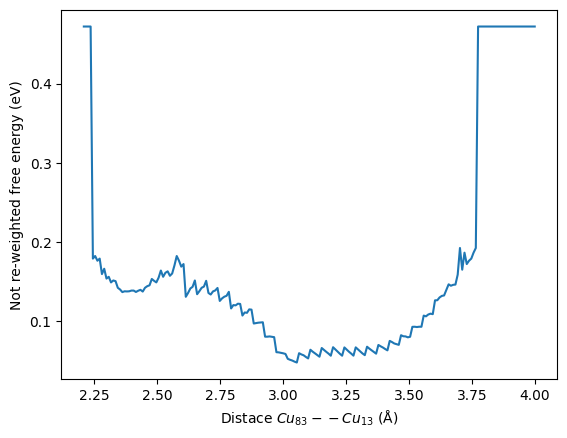

In [24]:
fig, ax = plt.subplots()
ax.plot(np.flip(histogram[1])[0:200],A0)
ax.set_xlabel("Distace $Cu_{83}--Cu_{13}$ (Å)")
ax.set_ylabel("Not re-weighted free energy (eV)")

In [25]:
Q = Q0 * np.exp(-beta*umbrellas)

## Question 3 (points 2)
### explain in few words the formula above (make a reference to the lecture)

In [26]:
# correct free energy after re-weighting
A = -np.log(Q)/beta

Text(0, 0.5, 'Re-weighted free energy (eV)')

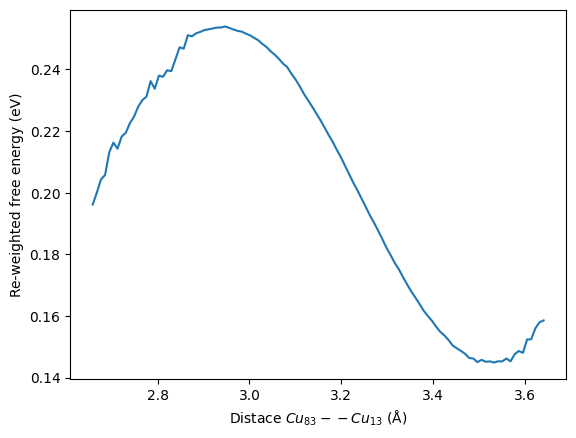

In [27]:
# in the following plots I cut the regions that were not explored by the adatom
fig, ax = plt.subplots()
ax.plot(np.flip(histogram[1])[40:150],A[40:150])
ax.set_xlabel("Distace $Cu_{83}--Cu_{13}$ (Å)")
ax.set_ylabel("Re-weighted free energy (eV)")
#plt.plot(np.flip(histogram[1])[0:200],A)

## Question 4 (points 2)
### the plot above should be almost symmetric. Discuss in few words why the result, in your opinion, is not symmetric and why some parts are quite "noisy"

## Enthalpy

In [28]:
#enthalpies

In [29]:
ref_ene=np.zeros_like(enthalpies)
# use the enthalpy of teh first configuration as reference energy
ref_ene.fill(get_energy(cua))
nonzero = histogram0!=0
enthalpies_avg = np.zeros_like(enthalpies)
np.place(enthalpies_avg, nonzero, enthalpies[nonzero]/histogram0[nonzero] - ref_ene[nonzero])

Text(0, 0.5, 'Averaged enthalpies(eV)')

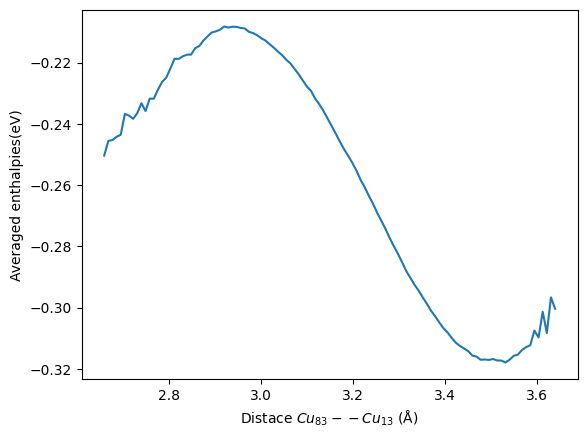

In [30]:
fig, ax = plt.subplots()
ax.plot(np.flip(histogram[1])[40:150],enthalpies_avg[40:150])
ax.set_xlabel("Distace $Cu_{83}--Cu_{13}$ (Å)")
ax.set_ylabel("Averaged enthalpies(eV)")
#plt.plot(np.flip(histogram[1])[0:200],enthalpies_avg)

## Question 5 (points 2)
#### Above is the plot of the algebraic average of the enthalpies for the configurations belonging to each distance interval in the histogram. Would you expect this plot to be similar to the free energy plot or not? Explain in few words.

In [31]:
# minimum distance reached 
np.amin(distances)

2.2370967363420613

In [32]:
# maximum distance reached
np.amax(distances)

3.763120566865158